In [75]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

In [76]:
with open("columns.txt", "r", encoding="utf-8") as f:
    columns = f.read().split("\n")

In [77]:
from sklearn.model_selection import train_test_split

df = pd.DataFrame(columns)
df.columns = ["text"]

In [83]:
test_set = pd.read_csv("test_set.csv")
test_set.drop(columns=["Unnamed: 0"])

,key,value
0,Speaking Test,시험
1,수업 참여 및 태도,태도
2,3회 온라인퀴즈,기타
3,포스터 발표 및 단원 리뷰,발표
4,중간시험(또는 과제),시험
...,...,...
995,실험1,실험
996,지도교수분반제3(참여도),참여도
997,발표 및 토론,발표
998,태도: 참여,태도


In [87]:
X = model.encode(test_set["key"].tolist(), show_progress_bar=True)
y = test_set["value"].tolist()

Batches: 100%|██████████| 32/32 [00:00<00:00, 38.62it/s]


In [93]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
train_losses = []

C:\Users\hyese\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\hyese\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\hyese\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\hyese\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\hyese\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.


최적의 C 값: 1.4384


LogisticRegression(C=1.438449888287663, max_iter=1000, random_state=42)

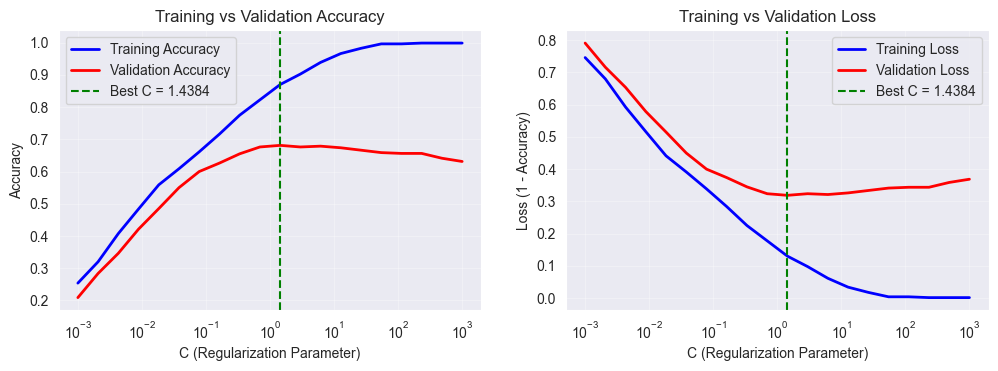

In [99]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

# 다양한 C 값으로 학습하여 검증 손실 추이 확인
C_values = np.logspace(-3, 3, 20)  # 0.001부터 1000까지
train_scores = []
val_scores = []

for C in C_values:
    clf = LogisticRegression(C=C, random_state=42, max_iter=1000)
    clf.fit(X_train, y_train)

    # 훈련 정확도
    train_score = clf.score(X_train, y_train)
    train_scores.append(train_score)

    # 교차 검증 점수 (작은 데이터셋이므로 3-fold 사용)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')
    val_scores.append(cv_scores.mean())

# 최적의 C 값 찾기
best_idx = np.argmax(val_scores)
best_C = C_values[best_idx]
print(f"\n최적의 C 값: {best_C:.4f}")

# 검증 손실 추이 그래프 생성
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.semilogx(C_values, train_scores, 'b-', label='Training Accuracy', linewidth=2)
plt.semilogx(C_values, val_scores, 'r-', label='Validation Accuracy', linewidth=2)
plt.axvline(x=best_C, color='g', linestyle='--', label=f'Best C = {best_C:.4f}')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# 검증 손실 (1 - accuracy)
plt.subplot(2, 2, 2)
train_loss = [1 - score for score in train_scores]
val_loss = [1 - score for score in val_scores]
plt.semilogx(C_values, train_loss, 'b-', label='Training Loss', linewidth=2)
plt.semilogx(C_values, val_loss, 'r-', label='Validation Loss', linewidth=2)
plt.axvline(x=best_C, color='g', linestyle='--', label=f'Best C = {best_C:.4f}')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Loss (1 - Accuracy)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 최적 모델로 최종 학습
final_clf = LogisticRegression(C=best_C, random_state=42, max_iter=1000)
final_clf.fit(X_train, y_train)


In [100]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, accuracy_score

# 예측
y_pred = final_clf.predict(X_test)
y_pred_proba = final_clf.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f"\n=== 최종 성능 평가 ===")
print(f"정확도 (Accuracy): {accuracy:.4f}")
print(f"정밀도 (Precision): {precision:.4f}")
print(f"재현율 (Recall): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


=== 최종 성능 평가 ===
정확도 (Accuracy): 0.7350
정밀도 (Precision): 0.7533
재현율 (Recall): 0.7350
F1-Score: 0.7389


In [8]:
keywords = ["시험 중간고사 기말고사", "attendance 출석", "과제 숙제 HW", "참여도 참석 참여 attendance", "발표 토론", "프로젝트 project", "협동 team", "보고서 essay", "실험", "태도"]
label = ["시험", "출석", "과제", "참여도", "발표", "프로젝트", "협동", "보고서", "실험", "태도", "기타"]

# 3. 임베딩
keyword_emb = model.encode(keywords)

# 4. 유사도 계산 (각 필드 vs 각 키워드)
similarities = cosine_similarity(embeddings, keyword_emb)
max_indices = np.argmax(similarities, axis=1)
max_values = np.max(similarities, axis=1)

# 5. 가장 유사한 키워드의 index로 라벨링
labels = []
scores = []
for idx, val in zip(max_indices, max_values):
    if val >= 0.38:
        labels.append(label[idx])
    else:
        labels.append("기타")
    scores.append(val)

df = pd.DataFrame()
df["field"] = columns
df["label"] = labels
df["scores"] = scores

In [9]:
df

,field,label,scores
0,출석,출석,0.611375
1,과제,시험,0.662664
2,중간고사,시험,0.693817
3,기말고사,시험,0.685169
4,참여,참여도,0.789256
...,...,...,...
4045,기말발표및과제,시험,0.639371
4046,탐구발표 및 출석,참여도,0.672374
4047,과제 및 탐구발표,실험,0.633757
4048,4 Homework,과제,0.716719


In [18]:
import pickle

field_to_label = dict(zip(df["field"], df["label"]))

# pickle로 저장
with open("평가방식.pickle", "wb") as f:
    pickle.dump(field_to_label, f)